# HRC Price Prediction for Japan
* Predict Japan's HRC price using regression on China's HRC price

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import datetime as dt

from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

## Correlation between HRC prices in China and Japan

In [2]:
# Read data of HRC price in China
df_CN = pd.read_csv('../data/processed/after_fillna.csv')
df_CN = df_CN[['Date', 'Month', 'HRC (FOB, $/t)']]

In [3]:
# Read data of HRC price in Japan
df_JP = pd.read_excel('../data/raw/Japan HRC FOB.xlsx')
df_JP.rename(columns={'Month': 'Month_JP'}, inplace=True)

In [4]:
# Merge data of the HRC prices in China and Japan
hrc_price_CN_JP = pd.concat([df_CN, df_JP], axis=1, ignore_index=False)
hrc_price_CN_JP

,Date,Month,"HRC (FOB, $/t)",Month_JP,Japan HRC FOB ($/t)
0,2006-01-01,Jan-06,388.0,2006-01-01,480
1,2006-02-01,Feb-06,388.0,2006-02-01,480
2,2006-03-01,Mar-06,449.0,2006-03-01,490
3,2006-04-01,Apr-06,478.0,2006-04-01,460
4,2006-05-01,May-06,505.0,2006-05-01,490
...,...,...,...,...,...
225,2024-10-01,Oct-24,497.0,2024-10-01,540
226,2024-11-01,Nov-24,485.0,2024-11-01,550
227,2024-12-01,Dec-24,473.0,2024-12-01,520
228,2025-01-01,Jan-25,461.0,2025-01-01,520


In [5]:
# Examine the data columns
hrc_price_CN_JP.columns

Index(['Date', 'Month', 'HRC (FOB, $/t)', 'Month_JP', 'Japan HRC FOB ($/t)'], dtype='object')

In [6]:
# Consolidate data column formats and drop the redundant column "Month" 
hrc_price_CN_JP.rename(columns={'HRC (FOB, $/t)': 'China HRC (FOB, $/t)',
                               'Japan HRC FOB ($/t)': 'Japan HRC (FOB, $/t)'}, inplace=True)
hrc_price_CN_JP['Date'] = hrc_price_CN_JP['Month_JP']
hrc_price_CN_JP.drop(['Month', 'Month_JP'], axis=1, inplace=True)
hrc_price_CN_JP.set_index('Date', inplace=True)
hrc_price_CN_JP

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2006-01-01,388.0,480
2006-02-01,388.0,480
2006-03-01,449.0,490
2006-04-01,478.0,460
2006-05-01,505.0,490
...,...,...
2024-10-01,497.0,540
2024-11-01,485.0,550
2024-12-01,473.0,520


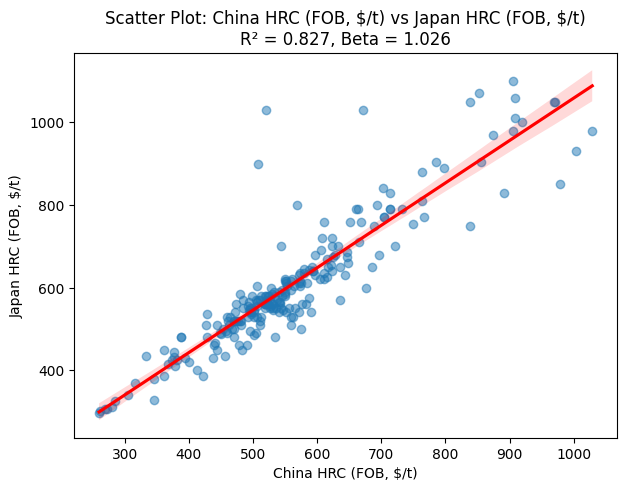

In [7]:
# Examine and visualise the correlation between HRC prices in China and Japan

x_col = 'China HRC (FOB, $/t)'
y_col = 'Japan HRC (FOB, $/t)'

# Drop NaN values for the current variable
temp_df = hrc_price_CN_JP[[x_col, y_col]].dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(temp_df[x_col], temp_df[y_col])
r_squared = r_value**2  # R² value

# Create plot
plt.figure(figsize=(7, 5))
sns.regplot(x=temp_df[x_col], y=temp_df[y_col], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

# Labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
x_col_name = x_col.replace("$", r"\$")
y_col_name = y_col.replace("$", r"\$")
plt.title(f"Scatter Plot: {x_col_name} vs {y_col_name}\nR² = {r_squared:.3f}, Beta = {slope:.3f}")

# Show plot
plt.show()

## Prediction of Japan HRC Prices using China's Prices

## Model Training

### Linear Regression (Time-Based Train-Test Split)

In [8]:
# Examine dataset dimensions for time-based train-test split later
print(temp_df.shape)
print(temp_df.shape[0] * 0.8)

(229, 2)
183.20000000000002


In [9]:
# Split dataset into train and test set (time-based)
# train set time period: Jan 2006 - Mar 2021
# test set time period: Apr 2021 - Jan 2025
df_train, df_test = temp_df[0:183], temp_df[183:]
X_train, X_test, y_train, y_test = df_train[["China HRC (FOB, $/t)"]], df_test[["China HRC (FOB, $/t)"]], df_train["Japan HRC (FOB, $/t)"], df_test["Japan HRC (FOB, $/t)"]

print(df_train.shape)
print(df_test.shape)

(183, 2)
(46, 2)


In [10]:
# Model fitting
model_linreg = LinearRegression()
model_linreg_fitted = model_linreg.fit(X_train, y_train)

In [11]:
# Model predictions
y_pred_linreg = model_linreg_fitted.predict(X_test)

In [12]:
# Get feature names and coefficients
feature_names_linreg = ["Intercept"] + list(X_train.columns)
intercept_linreg = model_linreg_fitted.intercept_
coef_linreg = model_linreg_fitted.coef_

coefficients_linreg = [intercept_linreg] + list(coef_linreg)

# Display results
pd.DataFrame({"Feature": feature_names_linreg, "Coefficient": coefficients_linreg})

,Feature,Coefficient
0,Intercept,69.732445
1,"China HRC (FOB, $/t)",0.949984


In [13]:
# Error metrics
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
r2_linreg = r2_score(y_test, y_pred_linreg)

print("Error metrics of linear regression model\n")
print('Mean Absolute Error: ', mae_linreg)
print('Mean Squared Error: ', mse_linreg)
print('Root Mean Squared Error: ', rmse_linreg)
print('R-squared: ', r2_linreg)

Error metrics of linear regression model

Mean Absolute Error:  35.212412363196236
Mean Squared Error:  3063.2257184577625
Root Mean Squared Error:  55.34641558816399
R-squared:  0.9086476727745469


In [14]:
def datetime_to_str(x):
    return pd.to_datetime(x).strftime('%b %Y')

In [15]:
len(datetime_to_str(df_test.index.to_numpy()))

46

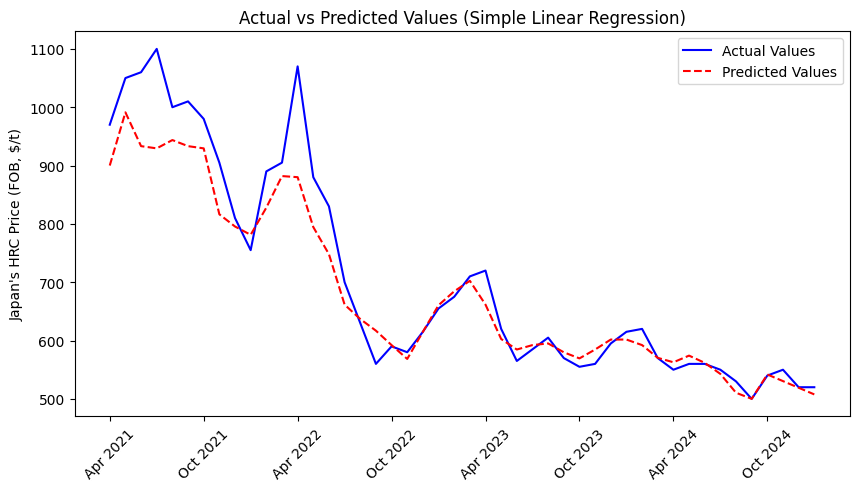

In [16]:
# Plot actual vs predicted Japan HRC Prices
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_linreg)), y_pred_linreg, label="Predicted Values", color="red", linestyle="dashed")

# Create x axis label from the datetime index
ind = datetime_to_str(df_test.index.to_numpy())
plt.xticks(range(0, len(ind)), ind, rotation=45)
plt.locator_params(axis='x', nbins=len(ind)/6) # Show the time as xticks every 6 months

plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Simple Linear Regression)")
plt.legend()
plt.show()

### Polynomial Regression (Time-Based Train-Test Split)

In [17]:
# Working with second degree polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)
poly

PolynomialFeatures(include_bias=False)

In [18]:
# Transform BOTH training and testing data
X_train_poly = poly.fit_transform(X_train)  # Fit and transform for training
X_test_poly = poly.transform(X_test)        # Only transform for testing

# Train the model using transformed training data
model_poly = LinearRegression()
model_poly_fitted = model_poly.fit(X_train_poly, y_train)

# Predict using the transformed test data
y_pred_poly = model_poly_fitted.predict(X_test_poly)

In [19]:
# Get feature names and coefficients
feature_names_poly = ["Intercept"] + list(poly.get_feature_names_out(input_features=X_train.columns))
intercept_poly = model_poly_fitted.intercept_
coef_poly = model_poly_fitted.coef_

coefficients_poly = [intercept_poly] + list(coef_poly)

# Display results
pd.DataFrame({"Feature": feature_names_poly, "Coefficient": coefficients_poly})

,Feature,Coefficient
0,Intercept,-39.860713
1,"China HRC (FOB, $/t)",1.339473
2,"China HRC (FOB, $/t)^2",-0.000327


In [20]:
# Error metrics
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print("Error metrics of polynomial regression model (degree = 2)\n")
print('Mean Absolute Error: ', mae_poly)
print('Mean Squared Error: ', mse_poly)
print('Root Mean Squared Error: ', rmse_poly)
print('R-squared: ', r2_poly)

Error metrics of polynomial regression model (degree = 2)

Mean Absolute Error:  41.09893524756452
Mean Squared Error:  4075.998688543329
Root Mean Squared Error:  63.84354852718737
R-squared:  0.8784444895057244


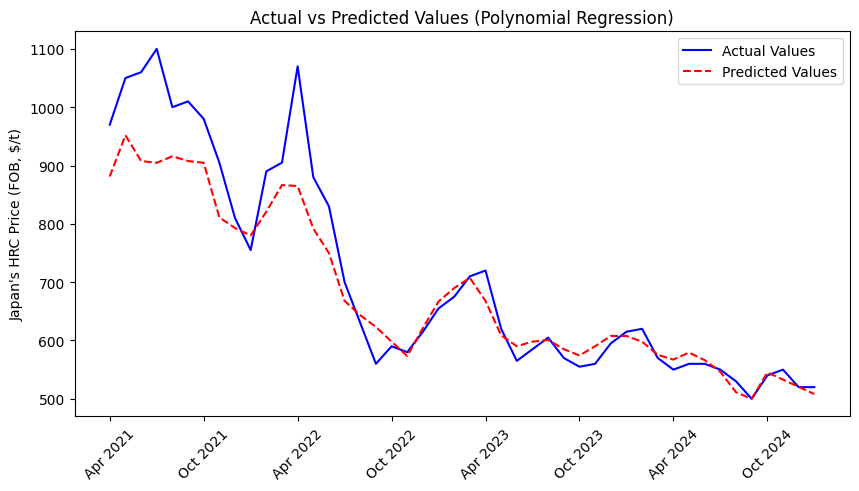

In [21]:
# Assuming y_test and y_pred are 1D arrays
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_poly)), y_pred_poly, label="Predicted Values", color="red", linestyle="dashed")

# Create x axis label from the datetime index
plt.xticks(range(0, len(ind)), ind, rotation=45)
plt.locator_params(axis='x', nbins=len(ind)/6) # Show the time as xticks every 6 months

plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Polynomial Regression)")
plt.legend()
plt.show()

### Linear Regression (Random Train-Test Split)

In [22]:
# Prepare X and y columns
X = temp_df[["China HRC (FOB, $/t)"]]
y = temp_df["Japan HRC (FOB, $/t)"]

# Split data into training (80%) and testing (20%) sets
X_train_rd, X_test_rd, y_train_rd, y_test_rd = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Model fitting
model_linreg_rd = LinearRegression()
model_linreg_fitted_rd = model_linreg_rd.fit(X_train_rd, y_train_rd)

# Model predictions
y_pred_linreg_rd = model_linreg_fitted_rd.predict(X_test_rd)

In [24]:
# Get feature names and coefficients
feature_names_linreg_rd = ["Intercept"] + list(X.columns)
intercept_linreg_rd = model_linreg_fitted_rd.intercept_
coef_linreg_rd = model_linreg_fitted_rd.coef_

coefficients_linreg_rd = [intercept_linreg_rd] + list(coef_linreg_rd)

# Display results
pd.DataFrame({"Feature": feature_names_linreg_rd, "Coefficient": coefficients_linreg_rd})

,Feature,Coefficient
0,Intercept,20.806508
1,"China HRC (FOB, $/t)",1.049746


In [25]:
# Error metrics
mae_linreg_rd = mean_absolute_error(y_test_rd, y_pred_linreg_rd)
mse_linreg_rd = mean_squared_error(y_test_rd, y_pred_linreg_rd)
rmse_linreg_rd = np.sqrt(mean_squared_error(y_test_rd, y_pred_linreg_rd))
r2_linreg_rd = r2_score(y_test_rd, y_pred_linreg_rd)

print("Error metrics of linear regression model (random train-test split)\n")
print('Mean Absolute Error: ', mae_linreg_rd)
print('Mean Squared Error: ', mse_linreg_rd)
print('Root Mean Squared Error: ', rmse_linreg_rd)
print('R-squared: ', r2_linreg_rd)

Error metrics of linear regression model (random train-test split)

Mean Absolute Error:  30.76859140133485
Mean Squared Error:  1829.6178131363527
Root Mean Squared Error:  42.77403199531642
R-squared:  0.9215976972213965


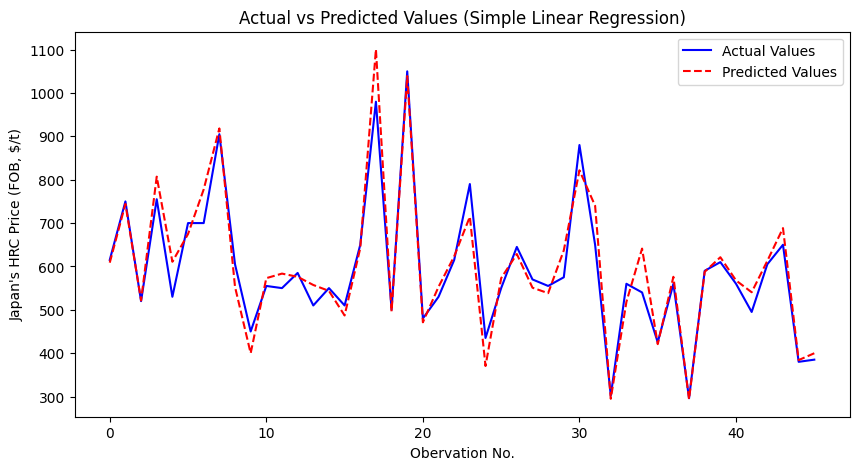

In [26]:
# Plot actual vs predicted Japan HRC Prices
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test_rd)), y_test_rd, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_linreg_rd)), y_pred_linreg_rd, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Simple Linear Regression)")
plt.legend()
plt.show()

### Polynomial Regression (Random Train-Test Split)

In [27]:
# Working with second degree polynomial
poly_rd = PolynomialFeatures(degree=2, include_bias=False)

# Transform BOTH training and testing data
X_train_poly_rd = poly_rd.fit_transform(X_train_rd)  # Fit and transform for training
X_test_poly_rd = poly.transform(X_test_rd)        # Only transform for testing

# Train the model using transformed training data
model_poly_rd = LinearRegression()
model_poly_fitted_rd = model_poly_rd.fit(X_train_poly_rd, y_train_rd)

# Predict using the transformed test data
y_pred_poly_rd = model_poly_fitted_rd.predict(X_test_poly_rd)

In [28]:
# Get feature names and coefficients
feature_names_poly_rd = ["Intercept"] + list(poly_rd.get_feature_names_out(input_features=X.columns))
intercept_poly_rd = model_poly_fitted_rd.intercept_
coef_poly_rd = model_poly_fitted_rd.coef_

coefficients_poly_rd = [intercept_poly_rd] + list(coef_poly_rd)

# Display results
pd.DataFrame({"Feature": feature_names_poly_rd, "Coefficient": coefficients_poly_rd})

,Feature,Coefficient
0,Intercept,-21.265600
1,"China HRC (FOB, $/t)",1.192575
2,"China HRC (FOB, $/t)^2",-0.000114


In [29]:
# Error metrics
mae_poly_rd = mean_absolute_error(y_test_rd, y_pred_poly_rd)
mse_poly_rd = mean_squared_error(y_test_rd, y_pred_poly_rd)
rmse_poly_rd = np.sqrt(mean_squared_error(y_test_rd, y_pred_poly_rd))
r2_poly_rd = r2_score(y_test_rd, y_pred_poly_rd)

print("Error metrics of polynomial regression model (degree = 2, random split)\n")
print('Mean Absolute Error: ', mae_poly_rd)
print('Mean Squared Error: ', mse_poly_rd)
print('Root Mean Squared Error: ', rmse_poly_rd)
print('R-squared: ', r2_poly_rd)

Error metrics of polynomial regression model (degree = 2, random split)

Mean Absolute Error:  31.64571987704406
Mean Squared Error:  1843.6559315433024
Root Mean Squared Error:  42.93781470386333
R-squared:  0.9209961394524016


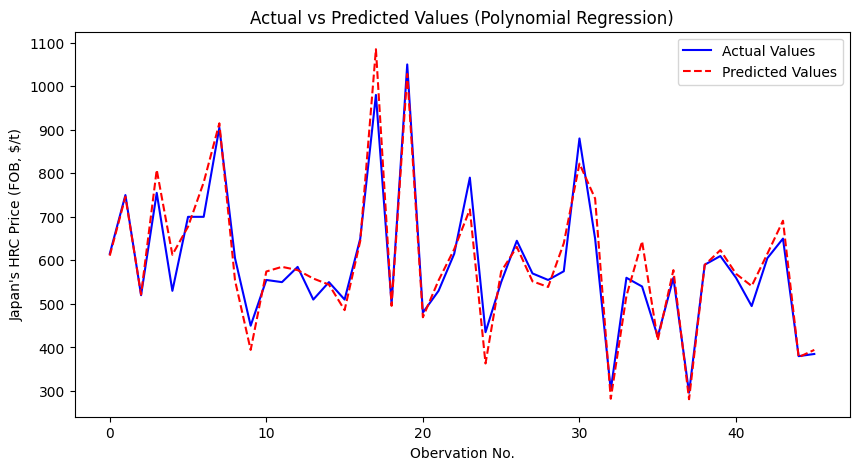

In [30]:
# Assuming y_test and y_pred are 1D arrays
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test_rd)), y_test_rd, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_poly_rd)), y_pred_poly_rd, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Polynomial Regression)")
plt.legend()
plt.show()

## Model Evaluationi & Selection

In [31]:
# Compare the four models
comparison_stats = {
    'Metric': ['Equation', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
    'Linear Regression (time-based)': [f"JP Price = {round(coef_linreg[0], 2)}*CN Price + {round(intercept_linreg, 2)}", mae_linreg, mse_linreg, rmse_linreg, r2_linreg],
    'Polynomial Regression with Degree=2 (time-based)': [f"JP Price = {round(coef_poly[1], 2)}*(CN Price)^2 + {round(coef_poly[0], 2)}*CN Price {round(intercept_poly, 2)}", mae_poly, mse_poly, rmse_poly, r2_poly],
    'Linear Regression (random)': [f"JP Price = {round(coef_linreg_rd[0], 2)}*CN Price + {round(intercept_linreg_rd, 2)}", mae_linreg_rd, mse_linreg_rd, rmse_linreg_rd, r2_linreg_rd],
    'Polynomial Regression with Degree=2 (random)': [f"JP Price = {round(coef_poly_rd[1], 2)}*(CN Price)^2 + {round(coef_poly_rd[0], 2)}*CN Price {round(intercept_poly_rd, 2)}", mae_poly_rd, mse_poly_rd, rmse_poly_rd, r2_poly_rd],
}

pd.set_option('display.max_colwidth', None) # to prevent truncation of output
pd.DataFrame(comparison_stats)

,Metric,Linear Regression (time-based),Polynomial Regression with Degree=2 (time-based),Linear Regression (random),Polynomial Regression with Degree=2 (random)
0,Equation,JP Price = 0.95*CN Price + 69.73,JP Price = -0.0*(CN Price)^2 + 1.34*CN Price -39.86,JP Price = 1.05*CN Price + 20.81,JP Price = -0.0*(CN Price)^2 + 1.19*CN Price -21.27
1,Mean Absolute Error,35.212412,41.098935,30.768591,31.64572
2,Mean Squared Error,3063.225718,4075.998689,1829.617813,1843.655932
3,Root Mean Squared Error,55.346416,63.843549,42.774032,42.937815
4,R-squared,0.908648,0.878444,0.921598,0.920996


As the **Linear Regression with random train-test split** shows the best performance amongst the four models, we will use this model for the forecast of Japan's HRC Price.

## Prediction of Japan's HRC Price

### Data Preparation

In [32]:
# Read predicted data for HRC price in China
hrc_CN_forecast = pd.read_csv('../data/final/multireg_forecast.csv')
hrc_CN_forecast.rename(columns={'HRC (FOB, $/t)_f': 'China HRC (FOB, $/t)'}, inplace=True)

date_index = hrc_CN_forecast['Date']
hrc_CN_forecast.drop(['Date'], axis=1, inplace=True)
hrc_CN_forecast.set_index(pd.DatetimeIndex(date_index), inplace=True)

hrc_CN_forecast

,"China HRC (FOB, $/t)"
Date,
2024-10-01,497.000000
2024-11-01,560.372873
2024-12-01,560.857291
2025-01-01,561.088248
2025-02-01,561.385992
2025-03-01,561.672284
2025-04-01,561.956906
2025-05-01,562.329086
2025-06-01,562.697665


In [33]:
# Dropping forecasted values before Feb 2025 as the actual data is available
hrc_CN_forecast = hrc_CN_forecast.loc[hrc_CN_forecast.index >= '2025-02-01']

In [34]:
# Re-examine the available data about HRC prices in China and Japan
hrc_price_CN_JP

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2006-01-01,388.0,480
2006-02-01,388.0,480
2006-03-01,449.0,490
2006-04-01,478.0,460
2006-05-01,505.0,490
...,...,...
2024-10-01,497.0,540
2024-11-01,485.0,550
2024-12-01,473.0,520


In [35]:
# Check for duplicates in the merged data
hrc_price_CN_JP = pd.concat([hrc_price_CN_JP, hrc_CN_forecast], axis=0, ignore_index=False)
duplicated_index = hrc_price_CN_JP[hrc_price_CN_JP.index.duplicated() == True].index.values
hrc_price_CN_JP.loc[hrc_price_CN_JP.index.isin(duplicated_index)]

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2025-02-01,NaN,535.0
2025-02-01,561.385992,NaN


In [36]:
# Drop duplicates - fill in NA values
hrc_price_CN_JP['China HRC (FOB, $/t)'] = hrc_price_CN_JP['China HRC (FOB, $/t)'].bfill() # fill with succeeding value
hrc_price_CN_JP['Japan HRC (FOB, $/t)'] = hrc_price_CN_JP['Japan HRC (FOB, $/t)'].ffill() # fill with preceeding value
hrc_price_CN_JP.loc[hrc_price_CN_JP.index.isin(duplicated_index)]

,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
Date,,
2025-02-01,561.385992,535.0
2025-02-01,561.385992,535.0


In [37]:
# Drop duplicates in the merged data
hrc_price_CN_JP.drop_duplicates(inplace=True)

# Dropping values after Feb 2025 (which will be forecasted)
hrc_price_CN_JP['Japan HRC (FOB, $/t)'] = hrc_price_CN_JP['Japan HRC (FOB, $/t)'].loc[hrc_price_CN_JP.index <= '2025-02-01']

# Export the data into a csv file
# The file will contain the China's HRC price from Jan 2006 to Mar 2025 (both actual and predicted),
# and the Japan's HRC price from Jan 2006 to Jan 2006 to Feb 2025 (actual only)
hrc_price_CN_JP.to_csv('../data/final/hrc_price_CN_JP.csv', index=True)

In [38]:
# Prepare China's HRC price for the period to be forecasted
x_CN = hrc_price_CN_JP[['China HRC (FOB, $/t)']].loc[hrc_price_CN_JP.index > '2025-02-01']
x_CN

,"China HRC (FOB, $/t)"
Date,
2025-03-01,561.672284
2025-04-01,561.956906
2025-05-01,562.329086
2025-06-01,562.697665
2025-07-01,563.085532
2025-08-01,563.478558
2025-09-01,563.858531
2025-10-01,564.240516
2025-11-01,564.609162


In [39]:
# Obtain y forecast (Japan's HRC price)
y_JP_forecast = model_linreg_fitted_rd.predict(x_CN)

#adding 10/1/2024 value to have a smooth line when plotting
y_JP_insert = hrc_price_CN_JP['Japan HRC (FOB, $/t)'].loc['2025-02-01']
y_JP_forecast_new = np.insert(y_JP_forecast, 0, y_JP_insert)

fc_period = pd.date_range(start='2025-02-01', end='2026-03-01', freq='MS')
df_forecast_JP = pd.DataFrame(y_JP_forecast_new, index=fc_period, columns=['Japan HRC (FOB, $/t)_f'])

df_forecast_JP

,"Japan HRC (FOB, $/t)_f"
2025-02-01,535.000000
2025-03-01,610.419805
2025-04-01,610.718585
2025-05-01,611.109280
2025-06-01,611.496195
2025-07-01,611.903357
2025-08-01,612.315933
2025-09-01,612.714809
2025-10-01,613.115796
2025-11-01,613.502781


In [40]:
# Export forecasted HRC price in China to a csv file
df_forecast_JP[1:].to_csv('../data/final/JP_forecast.csv', index=True)

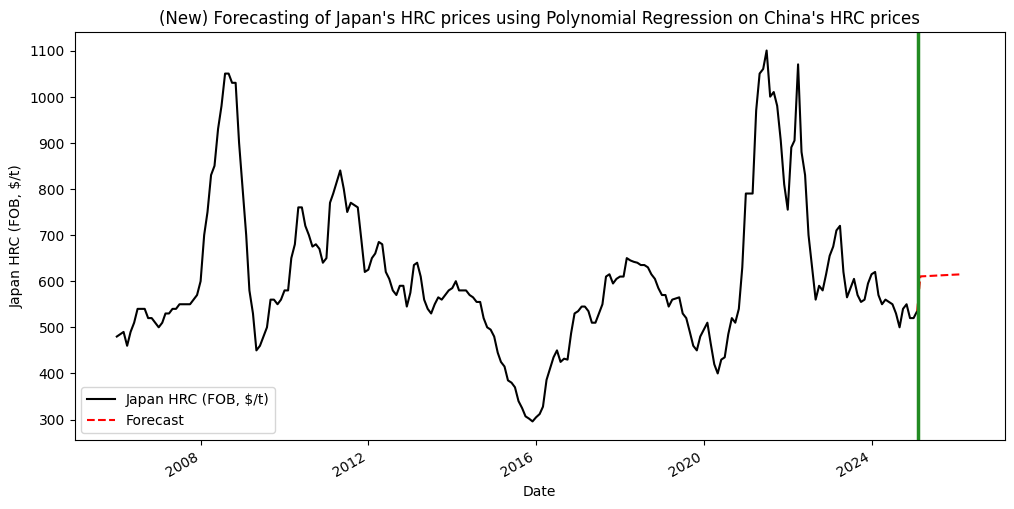

In [43]:
# Plot forecast
fig, ax = plt.subplots(figsize=(12, 6))

hrc_price_CN_JP['Japan HRC (FOB, $/t)'].plot(color='k')
df_forecast_JP['Japan HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("(New) Forecasting of Japan's HRC prices using Polynomial Regression on China's HRC prices")
plt.ylabel("Japan HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2025-02-10', linewidth = 2.5, color = 'forestgreen', linestyle = 'solid')
ax.legend()

In [42]:
# The following codes may be used for building the dashboard
'''
hrc_price_CN_JP = pd.read_csv('../data/final/hrc_price_CN_JP.csv', index=False)
hrc_price_CN_JP.dropna(inplace=True)

# Prepare X and y columns
X = hrc_price_CN_JP["China HRC (FOB, $/t)"]
y = hrc_price_CN_JP["Japan HRC (FOB, $/t)"]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Working with second degree polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transform training data for model testing
X_train_poly = poly.fit_transform(X_train)  # Fit and transform for training

# Train the model using transformed training data
model_poly = LinearRegression()
model_poly_fitted = model_poly.fit(X_train_poly, y_train)

# Use the trained model for prediction
# 1. Obtain x (China's HRC price with polynomial features)
x_CN = hrc_price_CN_JP[['China HRC (FOB, $/t)']].loc[hrc_price_CN_JP.index > '2025-02-01']
x_CN_poly_trans = poly.transform(x_CN) # transform China's HRC price to achieve polinomial features with degree=2

# 2. Obtain y forecast (Japan's HRC price)
y_JP_forecast = model_poly_fitted.predict(x_CN_poly_trans)
'''

'\nhrc_price_CN_JP = pd.read_csv(\'../data/final/hrc_price_CN_JP.csv\', index=False)\nhrc_price_CN_JP.dropna(inplace=True)\n\n# Prepare X and y columns\nX = hrc_price_CN_JP["China HRC (FOB, $/t)"]\ny = hrc_price_CN_JP["Japan HRC (FOB, $/t)"]\n\n# Split data into training (80%) and testing (20%) sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Working with second degree polynomial\npoly = PolynomialFeatures(degree=2, include_bias=False)\n\n# Transform training data for model testing\nX_train_poly = poly.fit_transform(X_train)  # Fit and transform for training\n\n# Train the model using transformed training data\nmodel_poly = LinearRegression()\nmodel_poly_fitted = model_poly.fit(X_train_poly, y_train)\n\n# Use the trained model for prediction\n# 1. Obtain x (China\'s HRC price with polynomial features)\nx_CN = hrc_price_CN_JP[[\'China HRC (FOB, $/t)\']].loc[hrc_price_CN_JP.index > \'2025-02-01\']\nx_CN_poly_trans = poly.transform(x_CN)